# **Important Libraries**

In [1]:
!pip install jsonlines

In [2]:
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc
import gensim
from gensim import corpora
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jsonlines
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])
import ipywidgets as widgets
from IPython.display import display, clear_output, Image, HTML
#warning
import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/google/colab/_import_hooks/_altair.py:16: DeprecationWarning:

the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Load Dataset**

In [3]:
DATA_PATH = "/kaggle/input/resume-dataset/Resume/Resume.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# **Load spaCy Model and Initialize Entity Ruler**

In [4]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:000:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
!wget https://raw.githubusercontent.com/kingabzpro/jobzilla_ai/refs/heads/main/jz_skill_patterns.jsonl

--2025-04-24 08:29:09--  https://raw.githubusercontent.com/kingabzpro/jobzilla_ai/refs/heads/main/jz_skill_patterns.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143937 (141K) [text/plain]
Saving to: ‘jz_skill_patterns.jsonl’

jz_skill_patterns.j 100%[===================>] 140.56K  --.-KB/s    in 0.007s  

2025-04-24 08:29:10 (19.4 MB/s) - ‘jz_skill_patterns.jsonl’ saved [143937/143937]



In [6]:
def load_spacy_model():
    """
    Load the spaCy model and add an entity ruler for skill and job category recognition.
    """
    # Load spaCy model
    nlp = spacy.load('en_core_web_lg')
    # Initialize and add entity ruler pipeline
    ruler = nlp.add_pipe('entity_ruler')
    skill_pattern_path = '/kaggle/working/jz_skill_patterns.jsonl'
    ruler.from_disk(skill_pattern_path)
    # Load dataset to get job categories
    global df
    job_categories = df["Category"].unique()
    for category in job_categories:
        ruler.add_patterns([{"label": "Job-Category", "pattern": category}])
    print("spaCy pipelines:", nlp.pipe_names)
    return nlp

nlp = load_spacy_model()

spaCy pipelines: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'entity_ruler']


# **Skills Extraction & Text Cleaning**

In [7]:
def get_skills(text, nlp):
    """
    Extract skills from a given text using the spaCy model.
    """
    doc = nlp(text)
    skills = [ent.text for ent in doc.ents if ent.label_ == "SKILL"]
    return skills

def unique_skills(skills):
    """
    Remove duplicate skills from a list.
    """
    return list(set(skills))

In [8]:
def clean_resume_text(text):
    """
    Clean resume text by removing special characters, lowering case, lemmatizing,
    and removing stopwords.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

In [9]:
def process_dataset(nlp, df):
    """
    Process the resume dataset by cleaning text and extracting skills.
    """
    clean_resumes = [clean_resume_text(resume) for resume in df["Resume_str"]]
    df["Clean_Resume"] = clean_resumes
    df["skills"] = df["Clean_Resume"].str.lower().apply(lambda x: get_skills(x, nlp))
    df["skills"] = df["skills"].apply(unique_skills)
    
    print("Dataset processing complete. Sample data:")
    print(df[["Category", "skills"]].head())
    return df

df = process_dataset(nlp, df)

Dataset processing complete. Sample data:
  Category                                             skills
0       HR  [marketing, segment, design, commerce, adverti...
1       HR  [marketing, design, advertising, support, soft...
2       HR  [marketing, advertising, information managemen...
3       HR  [certificate, interaction, process management,...
4       HR  [project management, support, business, data c...


# **Visualization**

In [20]:
def visualize_job_categories(df):
    """
    Visualize the distribution of job categories using a histogram.
    """
    fig = px.histogram(df, x="Category", title="Distribution of Job Categories")
    fig.show()

visualize_job_categories(df)

In [11]:
def visualize_skills_distribution(df, job_category= "ALL"):
    """
    Visualize the distribution of skills for a specific job category or all categories.
    When job_category is "ALL", aggregates skills across all resumes.
    """
    total_skills = []
    if job_category != "ALL":
        fltr = df[df["Category"] == job_category]["skills"]
        for skills in fltr:
            total_skills.extend(skills)
    else:
        for skills in df["skills"]:
            total_skills.extend(skills)
    
    fig = px.histogram(
        x=total_skills,
        labels={"x": "Skills"},
        title=f"{job_category} Distribution of Skills"
    )
    fig.update_xaxes(categoryorder="total descending")
    fig.show()

visualize_skills_distribution(df, job_category= "INFORMATION-TECHNOLOGY")

In [12]:
visualize_skills_distribution(df, job_category= "BUSINESS-DEVELOPMENT")

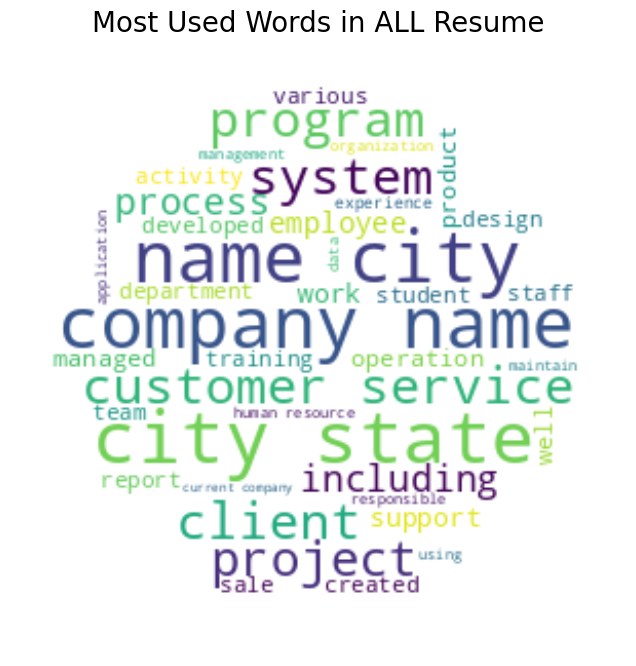

In [13]:
def generate_word_cloud(df, job_category):
    """
    Generate a word cloud for the most used words in resumes of a specific job category.
    When job_category is "ALL", includes words from all resumes.
    """
    text = " ".join(df[df["Category"] == job_category]["Clean_Resume"].values) if job_category != "ALL" else " ".join(df["Clean_Resume"].values)
    
    plt.figure(figsize=(8, 8))
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    
    wc = WordCloud(
        width=800,
        height=800,
        background_color="white",
        min_font_size=6,
        repeat=True,
        mask=mask
    )
    wc.generate(text)
    
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f"Most Used Words in {job_category} Resume", fontsize=20)
    plt.show()

generate_word_cloud(df, 'ALL')

In [14]:
# Visualize entities in the text using spaCy's displaCy.
sent = nlp(df["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

In [15]:
# Dependency Parsing
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

In [16]:
def calculate_match_score(input_resume, required_skills, nlp):
    """
    Calculate the percentage match of required skills in a resume.
    """
    print("\n=== Calculating Skills Match Score ===")
    req_skills = required_skills.lower().split(",")
    resume_skills = unique_skills(get_skills(input_resume.lower(), nlp))
    
    score = 0
    for skill in req_skills:
        if skill.strip() in resume_skills:
            score += 1
    
    match_percentage = round((score / len(req_skills)) * 100, 1)
    return match_percentage, resume_skills

In [17]:
# Test
input_resume = """
Mohamed Hisham Mohamed 
Data Scientist 
Alexandria, Egypt | mohamed.hishamk0@gmail.com | +20 155 519 7958 | Kaggle | GitHub | LinkedIn 
Profile_______________________________________________________________________________________
 Aspiring Data Scientist with a computer engineering background and hands-on AI experience. Skilled in Python, 
machine learning, and deep learning. Passionate about solving real-world problems using data. Seeking an 
internship to apply analytical skills, enhance model performance, and contribute to impactful, data-driven 
solutions in a collaborative environment. 
Education__________________________________________________________________________________
 Bachelor of Computer Engineering                                                                                          
sep 2022 – sep 2027 
Alexandria Higher Institute of Engineering and Technology 
Projects_____________________________________________________________________________________
 Medical Chatbot 
• Built a real-time Q&A system using LangChain, FAISS, and Mistral-7B with Streamlit UI. 
• Enabled source transparency by retrieving and displaying relevant medical documents. 
Tennis System Analysis 
• Developed a vision-based tracking system with YOLOv5, PyTorch, and OpenCV. 
• Tracked players and ball movement, generating shot statistics. 
• Visualized court coverage and trajectories for performance analysis. 
Image Caption Generator 
• Trained a captioning model using VGG16 and LSTM on the Flickr8k dataset. 
• Deployed with Streamlit for interactive captioning based on visual features. 
Brain Tumor Segmentation 
• Designed a U-Net in TensorFlow for precise MRI tumor segmentation. 
• Applied augmentation and visualization to enhance prediction accuracy. 
CERTIFICATES______________________________________________________________________________ 
AI & Machine Learning - AMIT Learning     Jun 2024 - Mar 2025   
Deep Learning using PyTorch – DataCamp       Jan 2025 - Feb 2025 
Machine Learning Specialization - Coursera        Jul 2024 - Sep 2024 
Master Computer Science - Route IT       Aug 2023 - Dec 2023 
Skills________________________________________________________________________________________ 
Tech Skills : Python, SQL, C++, Scikit-Learn, TensorFlow, PyTorch, Pandas, NumPy, Matplotlib, Seaborn, Plotly, 
OpenCV, OOP, Git, GitHub, MediaPipe, LangChain, NLTK, SpaCy. 
Soft Skills: Problem-solving, teamwork, collaboration. 
Languages: Arabic (native), English (B1). 
COMPETITIONS & VOLUNTEERING_______________________________________________ 
ECPC Qualifications 2024: Ranked 39th out of +500 in the regional ICPC contest (Day 1). 
Head of AI, Microsoft Student Branch – AIET : Led the AI division, organized workshops, mentored peers, and 
promoted hands-on learning in AI and machine learning.
"""

required_skills= "Python, Machine Learning, Deep Learning, SQL, TensorFlow, PyTorch, Scikit-Learn,NLP ,Git, GitHub"
calculate_match_score(input_resume, required_skills, nlp)


=== Calculating Skills Match Score ===


(70.0,
 ['opencv',
  'numpy',
  'git',
  'tensorflow',
  'computer science',
  'visualization',
  'python',
  'ai',
  'collaboration',
  'tracking system',
  'segmentation',
  'pandas',
  'pytorch',
  'github',
  'computer engineering',
  'deep learning',
  'plotly',
  'languages',
  'machine learning'])

# **Topic Modeling**

In [18]:
# Perform topic modeling using LDA to identify latent themes in resumes.
docs = df["Clean_Resume"].values
dictionary = corpora.Dictionary(d.split() for d in docs)
bow = [dictionary.doc2bow(d.split()) for d in docs]
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(
    bow, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=50, 
    minimum_probability=0
)
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.012*"state" + 0.011*"city" + 0.010*"company" + 0.010*"student" + 0.009*"marketing" + 0.008*"medium" + 0.008*"name" + 0.007*"event" + 0.007*"program" + 0.007*"communication"'),
 (1,
  '0.014*"management" + 0.012*"business" + 0.011*"company" + 0.010*"state" + 0.009*"sale" + 0.009*"city" + 0.008*"name" + 0.007*"financial" + 0.007*"client" + 0.007*"customer"'),
 (2,
  '0.021*"customer" + 0.012*"state" + 0.012*"service" + 0.011*"city" + 0.010*"company" + 0.009*"name" + 0.008*"skill" + 0.006*"sale" + 0.006*"work" + 0.005*"food"'),
 (3,
  '0.012*"project" + 0.011*"system" + 0.008*"state" + 0.007*"city" + 0.007*"company" + 0.007*"management" + 0.006*"name" + 0.006*"construction" + 0.005*"design" + 0.005*"training"')]

In [19]:
# Visualize 
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.015427  0.013334       1        1  37.201497
3     -0.004666 -0.151075       2        1  21.040664
0     -0.121749  0.076014       3        1  20.894706
2      0.141842  0.061727       4        1  20.863133, topic_info=            Term          Freq         Total Category  logprob  loglift
74      customer  11132.000000  11132.000000  Default  30.0000  30.0000
768      student   3176.000000   3176.000000  Default  29.0000  29.0000
175       medium   2725.000000   2725.000000  Default  28.0000  28.0000
469      project   7722.000000   7722.000000  Default  27.0000  27.0000
111    financial   4261.000000   4261.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
656  information   1084.372912   4245.451998   Topic4  -5.6642   0.2023
278         team   1083.728473   6687.002241   Topic4  -5.6648  -0.2526
264        staff    966.802616   3697.147558   Topic4  -5.7789   0.2259
168   management    927.227617  12017.888954   Topic4  -5.8207  -0.9948
287     training    905.933346   5611.269762   Topic4  -5.8440  -0.2564

[374 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6643      2  0.995087        3d
2043      1  0.051503  academic
2043      2  0.075416  academic
2043      3  0.866359  academic
2043      4  0.005518  academic
...     ...       ...       ...
1323      2  0.099549   writing
1323      3  0.745371   writing
1323      4  0.028620   writing
6952      2  0.994588       xml
1455      1  0.995932   yearend

[757 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])